<a href="https://colab.research.google.com/github/BonellPatinoE/CD48-in-myeloma/blob/main/CD48_Expression_in_HD%2C_MGUS%2C_SMM_and_MM_Scanpy_Zenodo_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.1 MB/s eta 0:00:00


In [3]:
file_path = "/content/drive/My Drive/scRNAseq data/panImmune.h5ad"

In [4]:
adata = sc.read_h5ad(file_path)

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 763657 × 34849
    obs: 'sample_id', 'study_id', 'donor_id', 'barcode', 'tissue', 'chem', 'sort', 'has_tcr', 'n_counts', 'log10_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_hb', 'pct_counts_ig', 'scr_doublet', 'scr_doublet_score', 'UMAP1', 'UMAP2', 'MDE1', 'MDE2', 'leiden_0.6', 'lineage', 'pheno'
    var: 'gene', 'n_counts', 'n_cells_by_counts', 'mt', 'hb', 'ig'
    uns: 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_mde', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'


In [6]:
adata.var_names[:5]  # Show first 5 gene names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1'], dtype='object')

In [7]:
adata.obs_names[:5]  # Show first 5 cell IDs

Index(['Foster_2024.MGUS1_pos:1', 'Foster_2024.MGUS1_pos:2',
       'Foster_2024.MGUS1_pos:3', 'Foster_2024.MGUS1_pos:4',
       'Foster_2024.MGUS1_pos:5'],
      dtype='object', name='obs_names')

In [8]:
print(adata.shape)  # (cells, genes)

(763657, 34849)


In [9]:
# Check unique cell types in the 'lineage' column
print(adata.obs['lineage'].unique())

['T cell', 'Progenitor', 'Doublet', 'PC', 'Myeloid', 'NK cell', 'B cell', 'Nonhaem', 'Platelet', 'Neutrophil']
Categories (10, object): ['B cell', 'Doublet', 'Myeloid', 'NK cell', ..., 'PC', 'Platelet',
                          'Progenitor', 'T cell']


In [10]:
# Check unique cell types in the 'sample_id' column
print(adata.obs['sample_id'].unique())

['Foster_2024.MGUS1_pos', 'Foster_2024.SMM9_neg', 'Foster_2024.SMM7_pos', 'Foster_2024.SMM3_neg', 'Foster_2024.SMM7_neg', ..., 'Stephenson_2021.CV0934', 'Stephenson_2021.CV0940', 'Stephenson_2021.CV0944', 'Foster_2024.MM2', 'Foster_2024.MM1']
Length: 214
Categories (214, object): ['Bailur_2019.hd1', 'Bailur_2019.hd2', 'Bailur_2019.hd3', 'Bailur_2019.hd4',
                           ..., 'Zheng_2021.P20190122-P', 'Zheng_2021.P20190122-T',
                           'Zheng_2021.P20190322-P', 'Zheng_2021.P20190322-T']


In [11]:
# Check unique cell types in the 'tissue' column
print(adata.obs['tissue'].unique())

['BM', 'PB']
Categories (2, object): ['BM', 'PB']


In [12]:
import re

# Define the patterns for each category
mm_patterns = r'Foster_2024.MM4_neg|Foster_2024.MM4_pos|Foster_2024.MM5_pos|Foster_2024.MM6_pos|Foster_2024.MM6_neg|' \
              r'Foster_2024.MM5_neg|Foster_2024.MM3_pos|Foster_2024.MM3_neg|Foster_2024.MM7_neg|Foster_2024.MM7_pos|' \
              r'Bailur_2019.mm2|Bailur_2019.mm5|Bailur_2019.mm4|Bailur_2019.mm3|Bailur_2019.mm11|Bailur_2019.mm10|' \
              r'Bailur_2019.mm8|Bailur_2019.mm6|Bailur_2019.mm1|Bailur_2019.mm7|Bailur_2019.mm9|' \
              r'Zavidij_2020.MM-5|Zavidij_2020.MM-1|Zavidij_2020.MM-8|Zavidij_2020.MM-6|Zavidij_2020.MM-3|' \
              r'Zavidij_2020.MM-7|Zavidij_2020.MM-4|Zheng_2021.P20181219-T|Zheng_2021.P20190122-P|' \
              r'Zheng_2021.P20190122-T|Zheng_2021.P20190322-P|Zheng_2021.P20190322-T|' \
              r'Liu_2021.77570_Primary|Liu_2021.59114_Primary|Liu_2021.83942_Primary|Liu_2021.58408_Primary|' \
              r'Liu_2021.47491_Primary|Liu_2021.57075_Primary|Liu_2021.37692_Primary|Liu_2021.60359_Primary|' \
              r'Liu_2021.56203_Primary|Maura_2023.PT11|Maura_2023.PT12|Maura_2023.PT18|Maura_2023.PT13|' \
              r'Maura_2023.PT15|Maura_2023.PT55|Maura_2023.PT78|Maura_2023.PT85|Maura_2023.PT03|' \
              r'Maura_2023.PT30|Maura_2023.PT32|Maura_2023.PT33|Maura_2023.PT39|Maura_2023.PT49|' \
              r'Maura_2023.PT58|Maura_2023.PT59|Maura_2023.PT63|Foster_2024.MM2|Foster_2024.MM1'
smm_patterns = r'Foster_2024.SMM9_neg|Foster_2024.SMM7_pos|Foster_2024.SMM3_neg|Foster_2024.SMM7_neg|' \
              r'Foster_2024.SMM9_pos|Foster_2024.SMM12_pos|Foster_2024.SMM6_neg|Foster_2024.SMM8_pos|' \
              r'Foster_2024.SMM8_neg|Foster_2024.SMM6_pos|Foster_2024.SMM12_neg|Foster_2024.SMM4_pos|' \
              r'Foster_2024.SMM5_pos|Foster_2024.SMM5_neg|Foster_2024.SMM4_neg|Foster_2024.SMM11_neg|' \
              r'Foster_2024.SMM10_pos|Foster_2024.SMM2_neg|Foster_2024.SMM1_pos|Foster_2024.SMM1_neg|' \
              r'Foster_2024.SMM2_pos|Foster_2024.SMM10_neg|Foster_2024.SMM11_pos|Foster_2024.SMM14_neg|' \
              r'Foster_2024.SMM14_pos|Foster_2024.SMM13_neg|Foster_2024.SMM13_pos|' \
              r'Zavidij_2020.SMMh-4|Zavidij_2020.SMMl-1|Zavidij_2020.SMMh-10|Zavidij_2020.SMMh-3|' \
              r'Zavidij_2020.SMMh-7|Zavidij_2020.SMMh-2|Zavidij_2020.SMMh-9|Zavidij_2020.SMMh-6|' \
              r'Zavidij_2020.SMMl-3|Zavidij_2020.SMMh-8|Zavidij_2020.SMMl-2|' \
              r'Liu_2021.47491_SMM|Liu_2021.58408_SMM|Liu_2021.37692_SMM'
mgus_patterns = r'Foster_2024.MGUS1_pos|Foster_2024.MGUS1_neg|' \
                r'Bailur_2019.mgus14|Bailur_2019.mgus13|Bailur_2019.mgus4|Bailur_2019.mgus3|' \
                r'Bailur_2019.mgus2|Bailur_2019.mgus5|Bailur_2019.mgus12|Bailur_2019.mgus10|' \
                r'Bailur_2019.mgus9|Bailur_2019.mgus7|Bailur_2019.mgus6|Bailur_2019.mgus1|' \
                r'Bailur_2019.mgus8|Bailur_2019.mgus11|' \
                r'Zavidij_2020.MGUS-1|Zavidij_2020.MGUS-4|Zavidij_2020.MGUS-3|' \
                r'Zavidij_2020.MGUS-2|Zavidij_2020.MGUS-6'
hd_patterns = r'Foster_2024.HD3_neg|Foster_2024.HD2_pos|Foster_2024.HD2_neg|' \
              r'Foster_2024.HD3_pos|Foster_2024.HD1_pos|Foster_2024.HD1_neg|' \
              r'Oetjen_2018.G|Oetjen_2018.S_T1|Oetjen_2018.U|Oetjen_2018.T|' \
              r'Oetjen_2018.W|Oetjen_2018.L|Oetjen_2018.B|Oetjen_2018.C_T1_S1|' \
              r'Oetjen_2018.O|Oetjen_2018.P|Oetjen_2018.M|Oetjen_2018.N|' \
              r'Oetjen_2018.Q|Oetjen_2018.J|Oetjen_2018.C_T1_S2|Oetjen_2018.A|' \
              r'Oetjen_2018.F|Oetjen_2018.C_T2|Oetjen_2018.S_T2|Oetjen_2018.K|' \
              r'Oetjen_2018.E|Oetjen_2018.H|Oetjen_2018.R|' \
              r'Bailur_2019.hd1|Bailur_2019.hd6|Bailur_2019.hd8|Bailur_2019.hd7|' \
              r'Bailur_2019.hd5|Bailur_2019.hd2|Bailur_2019.hd3|Bailur_2019.hd4|' \
              r'Zavidij_2020.NBM-10|Zavidij_2020.NBM-5|Zavidij_2020.NBM-9|' \
              r'Zavidij_2020.NBM-11|Zavidij_2020.NBM-2|Zavidij_2020.NBM-1|' \
              r'Zavidij_2020.NBM-8|Kfoury_2021.BMM4|Kfoury_2021.BMM8|Kfoury_2021.BMM3|' \
              r'Kfoury_2021.BMM9|Kfoury_2021.BMM5|Kfoury_2021.BMM6|Kfoury_2021.BMM2|' \
              r'Granja_2019.BMMC_D1T1|Granja_2019.BMMC_D1T2|Conde_2022.A29_BMA|' \
              r'Conde_2022.A31_BMA|Conde_2022.A36_BMA|Conde_2022.A36_BLD|' \
              r'Conde_2022.A35_BMA|Conde_2022.A35_BLD|Conde_2022.A37_BMA|' \
              r'Conde_2022.621B_BMA|Conde_2022.637C_BMA|Conde_2022.637C_BLD|' \
              r'Conde_2022.640C_BMA|Conde_2022.D503_BMA|Conde_2022.D503_BLD|' \
              r'Conde_2022.D496_BMA|Conde_2022.D496_BLD|Stephenson_2021.newcastle65|' \
              r'Stephenson_2021.MH8919226|Stephenson_2021.MH8919333|Stephenson_2021.MH8919332|' \
              r'Stephenson_2021.MH8919227|Stephenson_2021.MH8919283|Stephenson_2021.MH8919178|' \
              r'Stephenson_2021.MH8919177|Stephenson_2021.MH8919176|Stephenson_2021.MH8919179|' \
              r'Stephenson_2021.newcastle74|Stephenson_2021.MH8919282|Stephenson_2021.CV0904|' \
              r'Stephenson_2021.CV0902|Stephenson_2021.CV0911|Stephenson_2021.CV0929|' \
              r'Stephenson_2021.CV0915|Stephenson_2021.CV0917|Stephenson_2021.CV0939|' \
              r'Stephenson_2021.CV0926|Stephenson_2021.CV0934|Stephenson_2021.CV0940|' \
              r'Stephenson_2021.CV0944'

# Function to categorize sample_id
def categorize_sample(sample):
    if re.search(mm_patterns, sample, re.IGNORECASE):
        return "MM"
    elif re.search(smm_patterns, sample, re.IGNORECASE):
        return "SMM"
    elif re.search(mgus_patterns, sample, re.IGNORECASE):
        return "MGUS"
    elif re.search(hd_patterns, sample, re.IGNORECASE):
        return "HD"
    else:
        return "Unknown"  # Default to Unknown if no match is found

# Extract sample_ids from adata.obs
sample_ids = adata.obs['sample_id'].unique()

# Create the DataFrame
df = pd.DataFrame(sample_ids, columns=["sample_id"])

# Apply the function to categorize the sample_id
df["sample_category"] = df["sample_id"].apply(categorize_sample)

# Display the DataFrame
print(df[['sample_id', 'sample_category']])

                  sample_id sample_category
0     Foster_2024.MGUS1_pos            MGUS
1      Foster_2024.SMM9_neg             SMM
2      Foster_2024.SMM7_pos             SMM
3      Foster_2024.SMM3_neg             SMM
4      Foster_2024.SMM7_neg             SMM
..                      ...             ...
209  Stephenson_2021.CV0934              HD
210  Stephenson_2021.CV0940              HD
211  Stephenson_2021.CV0944              HD
212         Foster_2024.MM2              MM
213         Foster_2024.MM1              MM

[214 rows x 2 columns]


In [13]:
# Apply the function to categorize the sample_id and update adata.obs
adata.obs['sample_category'] = adata.obs['sample_id'].apply(categorize_sample)

# Check the result
print(adata.obs[['sample_id', 'sample_category']])

                                     sample_id sample_category
obs_names                                                     
Foster_2024.MGUS1_pos:1  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:2  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:3  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:4  Foster_2024.MGUS1_pos            MGUS
Foster_2024.MGUS1_pos:5  Foster_2024.MGUS1_pos            MGUS
...                                        ...             ...
Foster_2024.MM1:9015           Foster_2024.MM1              MM
Foster_2024.MM1:9016           Foster_2024.MM1              MM
Foster_2024.MM1:9017           Foster_2024.MM1              MM
Foster_2024.MM1:9018           Foster_2024.MM1              MM
Foster_2024.MM1:9019           Foster_2024.MM1              MM

[763657 rows x 2 columns]


In [14]:
import pandas as pd

# Example: Create a DataFrame for sample_id and sample_category comparison
sample_ids = adata.obs['sample_id'].unique()
df = pd.DataFrame(sample_ids, columns=["sample_id"])

# Apply the categorization function to the sample_id column
df["sample_category"] = df["sample_id"].apply(categorize_sample)

# Save the DataFrame to a CSV file
df.to_csv('/content/sample_comparison.csv', index=False)

# Provide a download link
from google.colab import files
files.download('/content/sample_comparison.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Replace sample_id with sample_category
adata.obs['sample_id'] = adata.obs['sample_category']

# Drop the sample_category column if no longer needed
adata.obs.drop('sample_category', axis=1, inplace=True)

# Check the result
print(adata.obs[['sample_id']])

                        sample_id
obs_names                        
Foster_2024.MGUS1_pos:1      MGUS
Foster_2024.MGUS1_pos:2      MGUS
Foster_2024.MGUS1_pos:3      MGUS
Foster_2024.MGUS1_pos:4      MGUS
Foster_2024.MGUS1_pos:5      MGUS
...                           ...
Foster_2024.MM1:9015           MM
Foster_2024.MM1:9016           MM
Foster_2024.MM1:9017           MM
Foster_2024.MM1:9018           MM
Foster_2024.MM1:9019           MM

[763657 rows x 1 columns]


In [16]:
# Filter adata for NK cells and BM tissue
pc_bm_adata = adata[(adata.obs['lineage'] == 'PC') & (adata.obs['tissue'] == 'BM')].copy()

In [17]:
# Check filtered data
print(pc_bm_adata)
print(pc_bm_adata.obs['sample_id'].value_counts())  # Verify category counts

AnnData object with n_obs × n_vars = 77981 × 34849
    obs: 'sample_id', 'study_id', 'donor_id', 'barcode', 'tissue', 'chem', 'sort', 'has_tcr', 'n_counts', 'log10_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_hb', 'pct_counts_ig', 'scr_doublet', 'scr_doublet_score', 'UMAP1', 'UMAP2', 'MDE1', 'MDE2', 'leiden_0.6', 'lineage', 'pheno'
    var: 'gene', 'n_counts', 'n_cells_by_counts', 'mt', 'hb', 'ig'
    uns: 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_mde', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'
sample_id
MM      56545
SMM     17537
HD       2156
MGUS     1743
Name: count, dtype: int64


In [18]:
print(pc_bm_adata.obs['scr_doublet'].dtype)
print(pc_bm_adata.obs['scr_doublet'].unique())

category
['False', 'True']
Categories (2, object): ['False', 'True']


In [19]:
print("Total cells before filtering:", pc_bm_adata.shape[0])

Total cells before filtering: 77981


In [20]:
print("Passing n_genes > 500:", pc_bm_adata[pc_bm_adata.obs['n_genes'] > 500].shape[0])

Passing n_genes > 500: 72131


In [21]:
print("Passing n_genes <= 50000:", pc_bm_adata[pc_bm_adata.obs['n_genes'] <= 5000].shape[0])

Passing n_genes <= 50000: 77803


In [22]:
print("Passing n_counts >= 1000:", pc_bm_adata[pc_bm_adata.obs['n_counts'] >= 1000].shape[0])

Passing n_counts >= 1000: 75499


In [23]:
print("Passing n_counts <= 10000:", pc_bm_adata[pc_bm_adata.obs['n_counts'] <= 10000].shape[0])

Passing n_counts <= 10000: 57342


In [24]:
print("Passing pct_counts_mt < 10:", pc_bm_adata[pc_bm_adata.obs['pct_counts_mt'] < 10].shape[0])

Passing pct_counts_mt < 10: 77980


In [25]:
print("Passing scr_doublet == True:", pc_bm_adata[pc_bm_adata.obs['scr_doublet'] == True].shape[0])

Passing scr_doublet == True: 0


In [26]:
# Apply QC filters
filtered_adata = pc_bm_adata[
    (pc_bm_adata.obs['n_genes'] > 500) &
    (pc_bm_adata.obs['n_genes'] <= 5000) &
    (pc_bm_adata.obs['n_counts'] >= 1000) &
    (pc_bm_adata.obs['n_counts'] <= 10000) &
    (pc_bm_adata.obs['pct_counts_mt'] < 10)  # Mitochondrial percentage filter
].copy()

# Check filtered data
print(filtered_adata)
print(filtered_adata.obs['sample_id'].value_counts())

AnnData object with n_obs × n_vars = 51286 × 34849
    obs: 'sample_id', 'study_id', 'donor_id', 'barcode', 'tissue', 'chem', 'sort', 'has_tcr', 'n_counts', 'log10_counts', 'n_genes', 'pct_counts_mt', 'pct_counts_hb', 'pct_counts_ig', 'scr_doublet', 'scr_doublet_score', 'UMAP1', 'UMAP2', 'MDE1', 'MDE2', 'leiden_0.6', 'lineage', 'pheno'
    var: 'gene', 'n_counts', 'n_cells_by_counts', 'mt', 'hb', 'ig'
    uns: 'leiden', 'log1p', 'neighbors', 'umap'
    obsm: 'X_mde', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'
sample_id
MM      43425
SMM      6573
HD        769
MGUS      519
Name: count, dtype: int64


In [27]:
### NEW ANALYSIS IN PC CELLS

hd_mm_adata = filtered_adata[filtered_adata.obs['sample_id'].isin(['HD', 'MGUS', 'SMM', 'MM'])].copy()

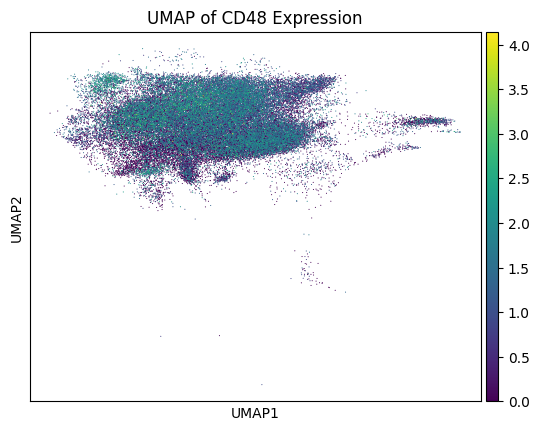

In [28]:
import scanpy as sc
import matplotlib.pyplot as plt

# Make sure CD48 is in the data
# Add the CD48 expression to the plotting
sc.pl.umap(hd_mm_adata, color='CD48', title='UMAP of CD48 Expression', show=True)


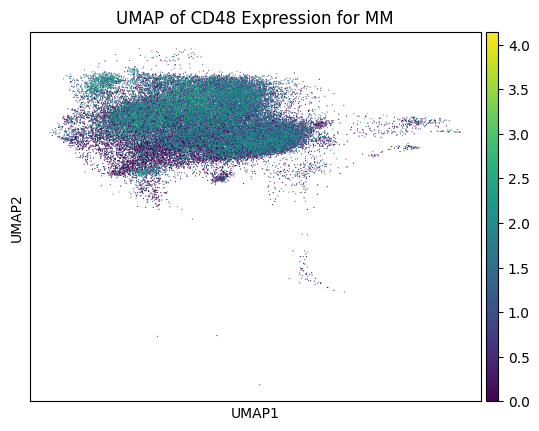

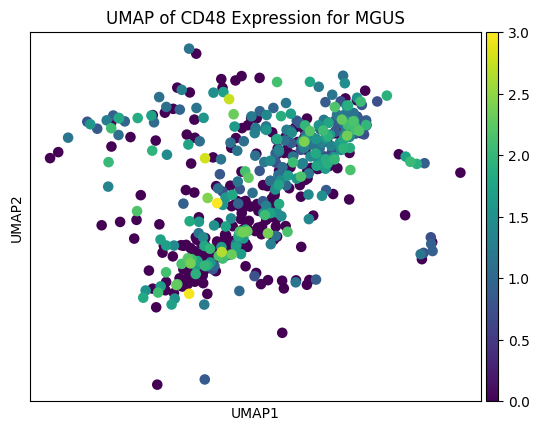

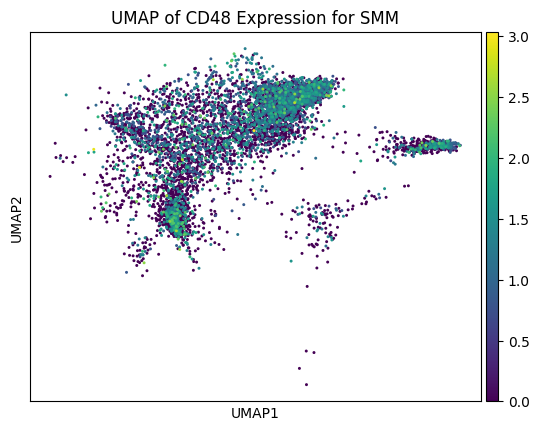

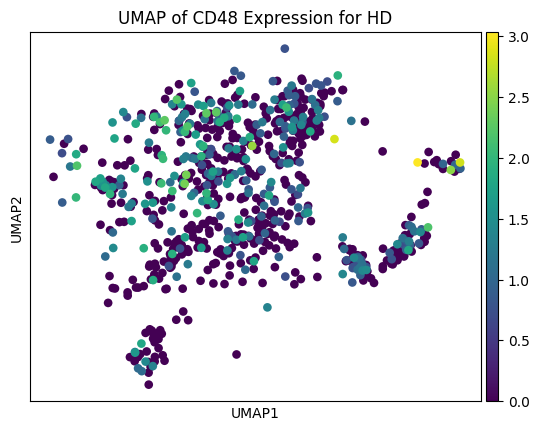

In [29]:
import scanpy as sc
import matplotlib.pyplot as plt

# Define conditions to subset by
conditions = ['MM', 'MGUS', 'SMM', 'HD']

# Loop through each condition to create a UMAP for that condition
for condition in conditions:
    # Subset the AnnData object to the current condition
    condition_adata = hd_mm_adata[hd_mm_adata.obs['sample_id'] == condition]

    # Plot UMAP for the current condition, specifying color for CD48 from the gene expression matrix
    # Use condition_adata.raw[:, 'CD48'].X to access gene expression if you had previously normalized the data
    sc.pl.umap(condition_adata, color=['CD48'], title=f'UMAP of CD48 Expression for {condition}', show=True, use_raw=False) # Edited line. Set 'use_raw' to False and provide 'color' as a list

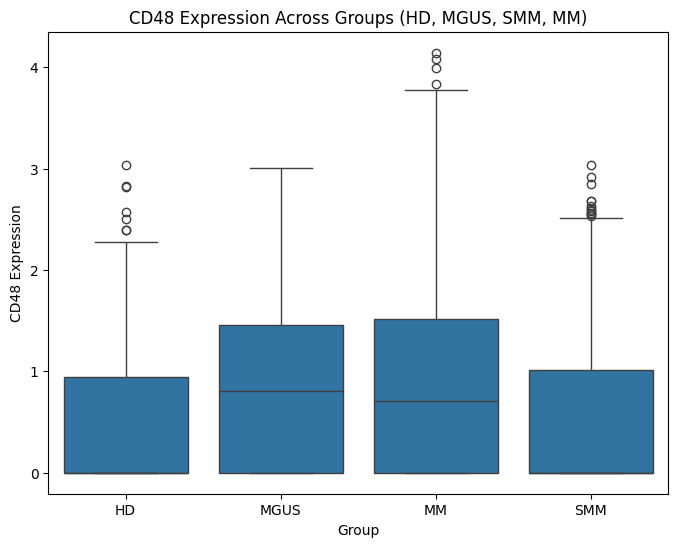

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fetch the CD48 expression values from the .X matrix using the gene name
CD48_expression = hd_mm_adata[:, 'CD48'].X.toarray().flatten()

# Add CD48 expression to the hd_mm_adata.obs DataFrame
hd_mm_adata.obs['CD48'] = CD48_expression

# Create a boxplot showing CD48 expression across the groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='sample_id', y='CD48', data=hd_mm_adata.obs)  # Now 'CD48' is in hd_mm_adata.obs
plt.title('CD48 Expression Across Groups (HD, MGUS, SMM, MM)')
plt.ylabel('CD48 Expression')
plt.xlabel('Group')
plt.show()

/tmp/ipython-input-3729526423.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sample_id', y='CD48', data=hd_mm_adata.obs, palette=palette, flierprops=flierprops)


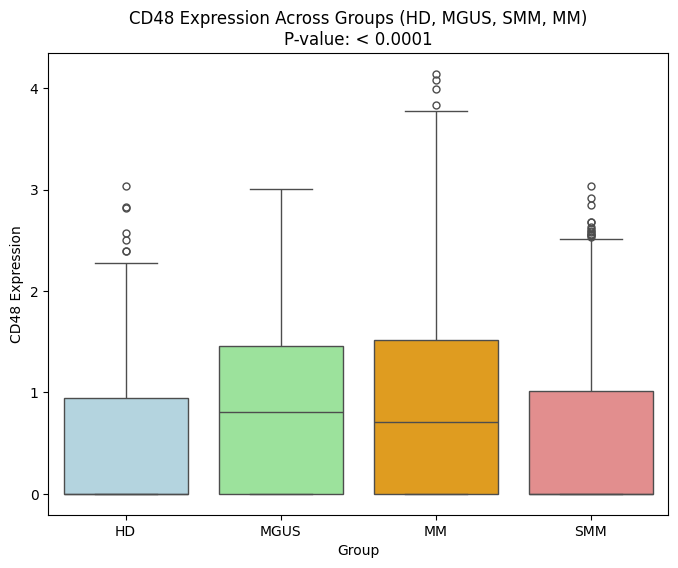

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats  # Import the necessary library

# Boxplot
plt.figure(figsize=(8, 6))

# Define custom colors for each group
palette = {'HD': 'lightblue', 'MGUS': 'lightgreen', 'SMM': 'lightcoral', 'MM': 'orange'}

# Define custom colors for outliers
flierprops = {'marker': 'o', 'color': 'red', 'markersize': 5}

# Create the boxplot with custom colors and outlier customization
sns.boxplot(x='sample_id', y='CD48', data=hd_mm_adata.obs, palette=palette, flierprops=flierprops)

# Perform the Kruskal-Wallis test
groups = [hd_mm_adata.obs['CD48'][hd_mm_adata.obs['sample_id'] == group] for group in ['HD', 'MGUS', 'SMM', 'MM']]
kruskal_result = scipy.stats.kruskal(*groups)

# Display p-value as "< 0.0001" if it's very small
p_value_display = f"< 0.0001" if kruskal_result.pvalue < 0.0001 else f"{kruskal_result.pvalue:.4f}"

# Add the p-value to the plot title
plt.title(f'CD48 Expression Across Groups (HD, MGUS, SMM, MM)\nP-value: {p_value_display}')
plt.ylabel('CD48 Expression')
plt.xlabel('Group')
plt.show()



/tmp/ipython-input-3510289822.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sample_id', y='CD48', data=hd_mm_adata.obs, palette=palette)


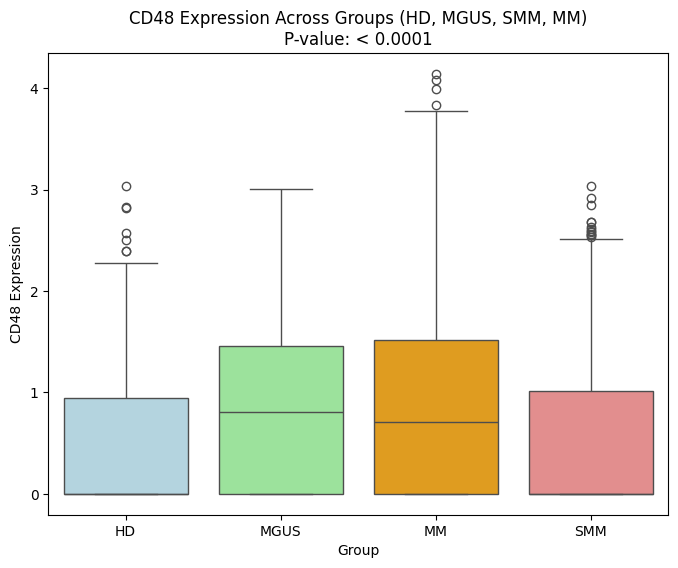

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats  # Import the necessary library

# Boxplot
plt.figure(figsize=(8, 6))

# Define custom colors for each group
palette = {'HD': 'lightblue', 'MGUS': 'lightgreen', 'SMM': 'lightcoral', 'MM': 'orange'}

# Create the boxplot with custom colors
sns.boxplot(x='sample_id', y='CD48', data=hd_mm_adata.obs, palette=palette)

# Perform the Kruskal-Wallis test
groups = [hd_mm_adata.obs['CD48'][hd_mm_adata.obs['sample_id'] == group] for group in ['HD', 'MGUS', 'SMM', 'MM']]
kruskal_result = scipy.stats.kruskal(*groups)

# Display p-value as "< 0.0001" if it's very small
p_value_display = f"< 0.0001" if kruskal_result.pvalue < 0.0001 else f"{kruskal_result.pvalue:.4f}"

# Add the p-value to the plot title
plt.title(f'CD48 Expression Across Groups (HD, MGUS, SMM, MM)\nP-value: {p_value_display}')
plt.ylabel('CD48 Expression')
plt.xlabel('Group')
plt.show()

Kruskal–Wallis p-value: 1.18934e-159 (display: < 0.0001)

Dunn (BH-adjusted) p-value matrix:
                 HD          MGUS            SMM             MM
HD    1.000000e+00  3.372186e-13   1.927181e-01   2.817911e-26
MGUS  3.372186e-13  1.000000e+00   3.337603e-15   5.400099e-01
SMM   1.927181e-01  3.337603e-15   1.000000e+00  1.903027e-141
MM    2.817911e-26  5.400099e-01  1.903027e-141   1.000000e+00

Dunn (BH-adjusted) pairwise p-values (unique pairs):
    group1 group2          p_adj
4      HD   MGUS   3.372186e-13
12     HD     MM   2.817911e-26
8      HD    SMM   1.927181e-01
13   MGUS     MM   5.400099e-01
9    MGUS    SMM   3.337603e-15
11     MM    SMM  1.903027e-141

Dunn RAW p-values and BH-adjusted across all 6 pairs:
    group1 group2          p_raw  p_adj_BH_allpairs
4      HD   MGUS   2.248124e-13       3.372186e-13
12     HD     MM   9.393037e-27       2.817911e-26
8      HD    SMM   1.605984e-01       1.927181e-01
13   MGUS     MM   5.400099e-01       5.400099e-01
9

/tmp/ipython-input-3689007312.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='group', y='expr', data=df_expr, order=order, palette=palette,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HD vs. MGUS: Custom statistical test, P_val:3.372e-13
MGUS vs. SMM: Custom statistical test, P_val:3.338e-15
SMM vs. MM: Custom statistical test, P_val:1.903e-141
HD vs. SMM: Custom statistical test, P_val:1.927e-01
MGUS vs. MM: Custom statistical test, P_val:5.400e-01
HD vs. MM: Custom statistical test, P_val:2.818e-26


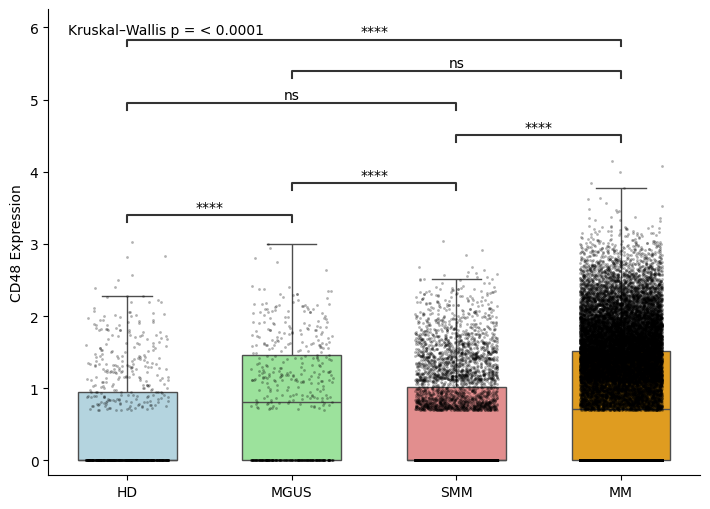

In [33]:
# === ALL-IN-ONE: ordering, KW test, Dunn pairwise (raw & BH), save CSV, annotate plot ===
!pip install -q scikit-posthocs statsmodels statannotations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from statannotations.Annotator import Annotator

# ---- 0) Build tidy DF from your AnnData (assumes hd_mm_adata.obs['CD48'] already exists) ----
df_expr = hd_mm_adata.obs[['sample_id','CD48']].rename(columns={'sample_id':'group', 'CD48':'expr'}).copy()
order = ['HD','MGUS','SMM','MM']
palette = {'HD':'lightblue','MGUS':'lightgreen','SMM':'lightcoral','MM':'orange'}
df_expr = df_expr[df_expr['group'].isin(order)]
df_expr['group'] = pd.Categorical(df_expr['group'], categories=order, ordered=True)

# ---- 1) Global Kruskal–Wallis ----
groups = [df_expr.loc[df_expr['group']==g, 'expr'].values for g in order]
kw = kruskal(*groups)
ptext = "< 0.0001" if kw.pvalue < 1e-4 else f"{kw.pvalue:.4g}"
print(f"Kruskal–Wallis p-value: {kw.pvalue:.6g} (display: {ptext})")

# ---- 2) Dunn’s post-hoc: BH-adjusted within the Dunn procedure (matrix + tidy long) ----
dunn_bh = sp.posthoc_dunn(df_expr, val_col='expr', group_col='group', p_adjust='fdr_bh')
print("\nDunn (BH-adjusted) p-value matrix:\n", dunn_bh)

def to_long(mat, colname):
    return (mat.reset_index()
             .melt(id_vars='index', var_name='group2', value_name=colname)
             .rename(columns={'index':'group1'})
             .astype({'group1': str, 'group2': str})
             .query('group1 < group2')
             .sort_values(['group1','group2']))

dunn_bh_long = to_long(dunn_bh, 'p_adj')
print("\nDunn (BH-adjusted) pairwise p-values (unique pairs):\n", dunn_bh_long)

# ---- 3) Dunn’s RAW p-values + optional BH across ALL 6 pairs ----
dunn_raw = sp.posthoc_dunn(df_expr, val_col='expr', group_col='group', p_adjust=None)   # <-- None (NOT "none")
dunn_raw_long = to_long(dunn_raw, 'p_raw')
dunn_raw_long['p_adj_BH_allpairs'] = multipletests(dunn_raw_long['p_raw'], method='fdr_bh')[1]
print("\nDunn RAW p-values and BH-adjusted across all 6 pairs:\n", dunn_raw_long)

# Save both tables to CSV (optional)
out = dunn_raw_long.merge(dunn_bh_long, on=['group1','group2'], how='left')
out.to_csv('/content/CD48_pairwise_Dunn_raw_and_BH.csv', index=False)
print("\nSaved: /content/CD48_pairwise_Dunn_raw_and_BH.csv")

# ---- 4) Plot (ordered) with jittered dots and annotate ALL pairs using Dunn BH p-values ----
pairs = [('HD','MGUS'), ('HD','SMM'), ('HD','MM'),
         ('MGUS','SMM'), ('MGUS','MM'), ('SMM','MM')]

# Map Dunn BH p-values to the pairs in the right order
bh_map = {(r.group1, r.group2): r.p_adj for _, r in dunn_bh_long.iterrows()}
pvals_for_pairs = [bh_map.get(pair, bh_map.get(tuple(reversed(pair)))) for pair in pairs]

plt.figure(figsize=(7.2,5.2))
ax = sns.boxplot(x='group', y='expr', data=df_expr, order=order, palette=palette,
                 showfliers=False, width=0.6)
sns.stripplot(x='group', y='expr', data=df_expr, order=order, color='k', alpha=0.30, size=2, jitter=0.25)

# Title with global p
ax.text(0.03, 0.97, f"Kruskal–Wallis p = {ptext}", transform=ax.transAxes, ha='left', va='top')

ax.set_xlabel('')
ax.set_ylabel('CD48 Expression')
sns.despine()

# Annotate with Dunn BH p-values (stars or numeric—you choose)
annot = Annotator(ax, pairs, data=df_expr, x='group', y='expr', order=order)
# Option A: show stars
annot.configure(text_format='star', show_test_name=False)
annot.set_pvalues_and_annotate(pvals_for_pairs)

# Option B: to show numbers instead, uncomment the next 3 lines and comment out set_pvalues_and_annotate above:
# annot.configure(text_format='simple', show_test_name=False)
# annot.set_pvalues_and_annotate(pvals_for_pairs)
# # (Will render "p = ..."; you can tweak formatting in the library if desired.)

plt.tight_layout()
plt.show()
